In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [27]:
%load_ext autoreload
%autoreload 2
#from xrayproject.utils_DAM import load_pngs, spurious_funct, spurious_funct_2, \
#get_img_sizes, get_img_heights, get_img_widths
from xrayproject.preprocessing import flip_resize, normalize
from xrayproject.utils_CH import load_train, load_masks
from xrayproject import utils_CH
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
from PIL import Image
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
pip install -q git+https://github.com/tensorflow/examples.git

Note: you may need to restart the kernel to use updated packages.


In [4]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

In [81]:
path_mask = '../raw_data/mask'
path = '../raw_data/raw_China/CXR_png'
masks, targets, ID = load_masks(100, get_all = False, get_random = False, balanced = True, path = path_mask)
images, ID = load_train(path, ID )
print(images[4].shape)
print(masks[4].shape)

Using path:  ../raw_data/mask
(2448, 2371, 3)
(2448, 2371, 1)


In [123]:
resized = [flip_resize(images[i], masks[i], input_shape=(224,224)) for i in range(len(images))]
print(resized[49][3].shape)

(224, 224, 1)


In [124]:
x1 = [n[0] for n in resized]
x2 = [n[2] for n in resized]

y1= [n[1] for n in resized]
y2 = [n[3] for n in resized]

In [125]:
image_dataset = x1 + x2
mask_dataset = y1 + y2 


image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [136]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.3)

In [127]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(140, 224, 224, 3) (60, 224, 224, 3)
(140, 224, 224, 1) (60, 224, 224, 1)


# Tensorflow example model

In [128]:
OUTPUT_CHANNELS = 1

In [129]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [130]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [131]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [137]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [138]:
TRAIN_LENGTH = len(X_test)
BATCH_SIZE = 16
BUFFER_SIZE = 10
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [139]:
#from keras.callbacks import EarlyStopping
#early = EarlyStopping(monitor='loss', patience=0.3, verbose=1, mode="min")
#callbacks_list = [early]

In [140]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(X_train,y_train ,epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps = VALIDATION_STEPS,
                          validation_data=(X_test, y_test)
                          #callbacks=callbacks_list)

Epoch 1/20
3/3 [==============================] - 21s 6s/step - loss: 0.8732 - accuracy: 0.5290
Epoch 2/20
3/3 [==============================] - 20s 7s/step - loss: 0.6067 - accuracy: 0.7335
Epoch 3/20
3/3 [==============================] - 25s 8s/step - loss: 0.4409 - accuracy: 0.8461
Epoch 4/20
3/3 [==============================] - 20s 7s/step - loss: 0.3593 - accuracy: 0.8391
Epoch 5/20
3/3 [==============================] - 19s 6s/step - loss: 0.3194 - accuracy: 0.8161
Epoch 6/20
3/3 [==============================] - 17s 6s/step - loss: 0.2959 - accuracy: 0.8105
Epoch 7/20
3/3 [==============================] - 18s 6s/step - loss: 0.2739 - accuracy: 0.8202
Epoch 8/20
3/3 [==============================] - 19s 6s/step - loss: 0.2512 - accuracy: 0.8348
Epoch 9/20
3/3 [==============================] - 22s 8s/step - loss: 0.2282 - accuracy: 0.8542
Epoch 10/20
3/3 [==============================] - 20s 7s/step - loss: 0.2070 - accuracy: 0.8813
Epoch 11/20
3/3 [======================

In [152]:
clam_1 = model.predict(X_test[1][tf.newaxis, ...]).squeeze();

In [153]:
clammy_2 = (1+np.sign(np.resize(clam_1,(224,224,1))))/2
print(clammy_2.max())
print(clammy_2.min())
clammy_2.shape

1.0
0.0


(224, 224, 1)

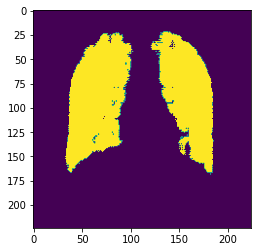

(224, 224, 1)


In [154]:
plt.imshow(clammy_2)
plt.show()
print(clammy_2.shape)

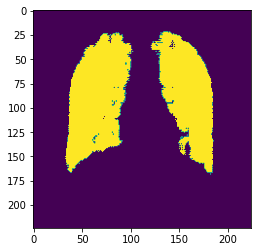

(224, 224, 1)


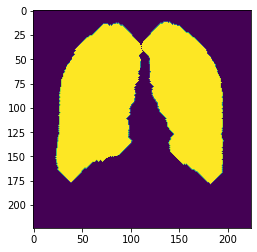

(224, 224, 1)


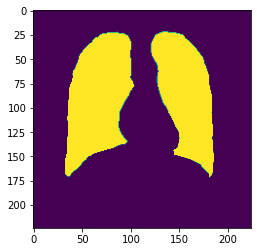

(224, 224, 1)


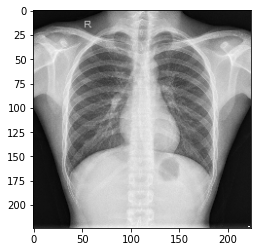

(224, 224, 3)


In [188]:

plt.imshow(clammy_2)
plt.show()
print(clammy_2.shape)

plt.imshow(clammy_3)
plt.show()
print(clammy_2.shape)

plt.imshow(y_test[1])
plt.show()
print(y_test[1].shape)

plt.imshow(X_test[1])
plt.show()
print(X_test[1].shape)

In [187]:
import scipy
from scipy import ndimage
clammy_3 = ndimage.binary_dilation(clammy_2, iterations=10)

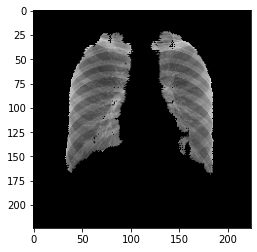

(224, 224, 1)


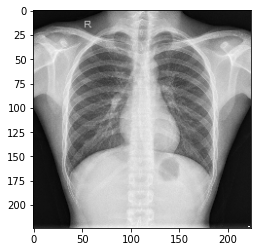

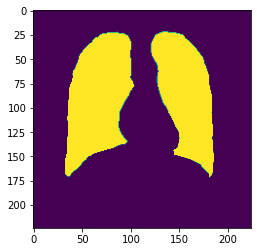

In [175]:
plt.imshow(X_test[1]*clammy_2)
plt.show()

print(y_test[1].shape)

plt.imshow(X_test[1])
plt.show()
plt.imshow(y_test[1])
plt.show()
#print(model.predict(X_test[1][tf.newaxis, ...]).squeeze().shape)

#plt.imshow( model.predict(X_test[1][tf.newaxis, ...]).squeeze() )
#plt.show()

#print(type(model.predict(X_test[1][tf.newaxis, ...]).squeeze()) )

(224, 224)
<class 'numpy.ndarray'>


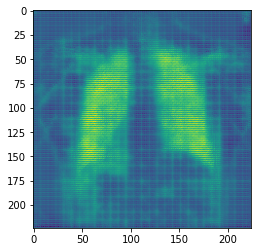

(224, 224, 1)


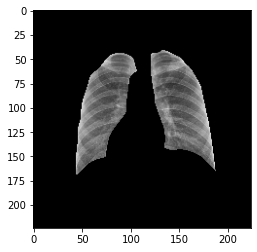

In [26]:
print(model.predict(X_test[1][tf.newaxis, ...]).squeeze().shape)
print(type(model.predict(X_test[1][tf.newaxis, ...]).squeeze()) )

plt.imshow( model.predict(X_test[1][tf.newaxis, ...]).squeeze() )
plt.show()

print(y_test[1].shape)

plt.imshow(X_test[1]*y_test[1])
plt.show()

# Montgomory test

### Load left and right masks with load_masks and load_train function:

In [4]:
MONTGOMERY_LEFT_MASK_DIR = '../raw_data/raw_USA/ManualMask/leftMask'

MONTGOMERY_RIGHT_MASK_DIR = '../raw_data/raw_USA/ManualMask/rightMask'

#path_mask = '../raw_data/mask'
#path = '../raw_data/raw_China/CXR_png'
left,targets, ID = load_masks(10, get_all = False, get_random = False, balanced = True, path = MONTGOMERY_LEFT_MASK_DIR)
right, ID = load_train(MONTGOMERY_RIGHT_MASK_DIR, ID)
print(left[4].shape)
print(right[4].shape)

Using path:  ../raw_data/raw_USA/ManualMask/leftMask
(4892, 4020, 1)
(4892, 4020, 1)


### Combine left and right mask to one image

In [71]:
def combine_left_right(left_mask, right_mask):
    index = list(range(0, (len(left_mask))))
    mask = []
    for i in index:
        combination = np.maximum(left_mask[i], right_mask[i])
        mask.append(combination)
    return mask

In [72]:
mask = combine_left_right(left, right)

In [73]:
print(mask[0].shape)
print(left[0].shape)
print(right[0].shape)

(4020, 4892, 1)
(4020, 4892, 1)
(4020, 4892, 1)


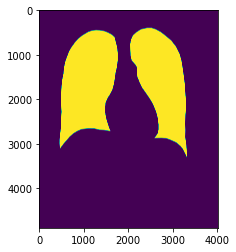

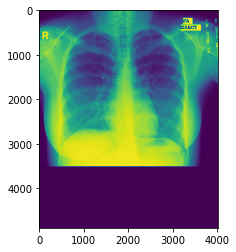

In [99]:
plt.imshow(mask[1])
plt.show()
#plt.imshow(left[5])
#plt.show()
#plt.imshow(right[5])
#plt.show()
plt.imshow(images[1])
plt.show()

## Get X-ray images

In [75]:
MONTGOMERY_XRAY = '../raw_data/raw_USA/CXR_png'

#path_mask = '../raw_data/mask'
#path = '../raw_data/raw_China/CXR_png'
#left,targets, ID = load_masks(10, get_all = False, get_random = False, balanced = True, path = MONTGOMERY_LEFT_MASK_DIR)
images, ID = load_train(MONTGOMERY_XRAY, ID)

## Resize

In [82]:
resized = [flip_resize(mask[i], images[i], input_shape=(224,224)) for i in range(len(images))]
#print(resized[49][3].shape)

In [96]:
print(resized[2][0].shape)

(224, 224, 1)


In [100]:
x1 = [n[0] for n in resized]
x2 = [n[2] for n in resized]

y1= [n[1] for n in resized]
y2 = [n[3] for n in resized]

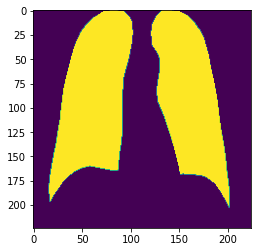

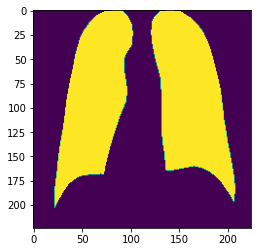

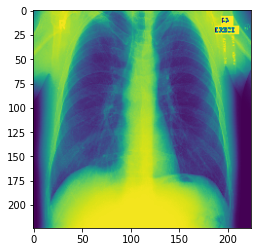

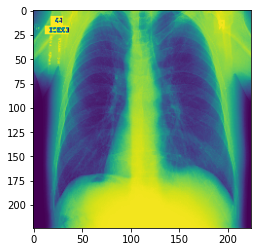

In [106]:
plt.imshow(x1[0])
plt.show()
plt.imshow(x2[0])
plt.show()
plt.imshow(y1[0])
plt.show()
plt.imshow(y2[0])
plt.show()

In [108]:
image_dataset = x1 + x2
mask_dataset = y1 + y2 

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

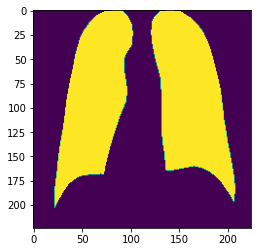

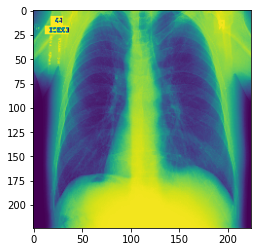

In [110]:
plt.imshow(image_dataset[10])
plt.show()
plt.imshow(mask_dataset[10])
plt.show()

# Function Load USA images+masks

In [29]:
from xrayproject.combomask import combine_left_right
from xrayproject import combomask

In [101]:
path = '../raw_data/raw_USA/CXR_png'
left_mask = '../raw_data/raw_USA/ManualMask/leftMask'
right_mask = '../raw_data/raw_USA/ManualMask/rightMask'

In [96]:
def USA_data(path, path_right, path_left):
    left,targets, ID = load_masks(10, get_all = False, get_random = False, balanced = True, path = path_left)
    right, ID = load_train(ID, path_right)
    USA_masks = combine_left_right(left, right)
    USA_images, ID = load_train(ID, path)
    return USA_masks, USA_images

In [97]:
test3, test4 = USA_data(path,right_mask, left_mask)

Using path:  ../raw_data/raw_USA/ManualMask/leftMask
Using bucket 
Loading local file:  ../raw_data/raw_USA/ManualMask/leftMask/MCUCXR_0023_0.png
Loading local file:  ../raw_data/raw_USA/ManualMask/leftMask/MCUCXR_0383_1.png
Loading local file:  ../raw_data/raw_USA/ManualMask/leftMask/MCUCXR_0103_0.png
Loading local file:  ../raw_data/raw_USA/ManualMask/leftMask/MCUCXR_0162_1.png
Loading local file:  ../raw_data/raw_USA/ManualMask/leftMask/MCUCXR_0082_0.png
Loading local file:  ../raw_data/raw_USA/ManualMask/leftMask/MCUCXR_0042_0.png
Loading local file:  ../raw_data/raw_USA/ManualMask/leftMask/MCUCXR_0367_1.png
Loading local file:  ../raw_data/raw_USA/ManualMask/leftMask/MCUCXR_0005_0.png
Loading local file:  ../raw_data/raw_USA/ManualMask/leftMask/MCUCXR_0040_0.png
Loading local file:  ../raw_data/raw_USA/ManualMask/leftMask/MCUCXR_0038_0.png
Loading local file:  ../raw_data/raw_USA/ManualMask/rightMask/MCUCXR_0023_0.png
Loading local file:  ../raw_data/raw_USA/ManualMask/rightMask/M

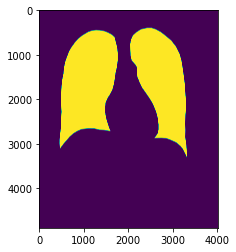

(4892, 4020, 1)


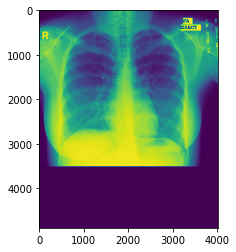

(4892, 4020, 1)


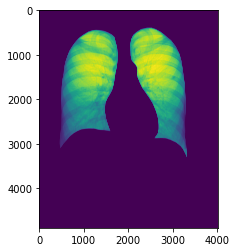

In [104]:
plt.imshow(test3[1])
plt.show()
print(test3[1].shape)
plt.imshow(test4[1])
plt.show()
print(test4[1].shape)
plt.imshow(test3[1]*test4[1])
plt.show()